本记录是对使用的SMV方法的调参记录，主要内容是对核函数的更换测试，以便找到相对合适的核函数

由于本人能力有限，参与的项目相对较少，调出的结果想必不是最好的，还希望各位多加指教

依照吴恩达的见解

1.如果Feature的数量很大，与样本数量差不多，此时选用LR或者是Linear Kernel的SVM

2.如果Feature的数量比较小，样本数量一般，不算大也不算小，选用SVM+Gaussian Kernel

3.如果Feature的数量比较小，而样本数量很多，需要手工添加一些feature变成第一种情况

本次实验样本5169条，特征8180条，明显属于第一条

SVM的特点决定了其在此问题中的表现

SVM的原理不涉及概率与大数定律等问题，是一种理论坚实的小样本学习方法，在样本不大的条件下，通常具有高效快速的特点

且其最终决策函数只有少量的支持向量决定，计算的复杂性计算的复杂性取决于支持向量的数目,而不是样本空间的维数,这在某种意义上避免了“维数灾难”。这在文本分类问题中尤为重要

但是核函数的选取需要大量的测试进行。



使用poly核函数的测试（多项式核函数）

需要调整的量

degree:int型参数 默认为3     这个参数只对多项式核函数有用，是指多项式核函数的阶数n

gamma越大，支持向量越少，gamma值越小，支持向量越多。gamma过大将导致过拟合，过小将导致欠拟合,如果gamma为auto，代表其值为样本特征数的倒数，即1/n_features.

coef0:float参数 默认为0.0,核函数中的独立项，只有对‘poly’和‘sigmod’核函数有用，是指其中的参数c

tol: float参数 默认为1e^-3,svm停止训练的误差精度,对泛化能力有影响，可以适当调大，但是不能太大，太大就变成欠拟合了．

class_weight：字典类型或者‘balance’字符串。默认为None。给每个类别分别设置不同的惩罚参数C，如果没有给，则会给所有类别都给C=1，即前面参数指出的参数C。C>0时,我们称为软间隔SVM.

其中 C是惩罚系数，即对误差的宽容度。C越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。C过大或过小，泛化能力变差



class_weight若设为balance一般效果较佳，但是需要保证各个类别平衡，此处设置为None

In [5]:
# coding=utf-8
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz # doctest: +SKIP
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
import snowballstemmer
from nltk import SnowballStemmer

sms_data = pd.read_csv("E:/finalpaper/smm.csv",encoding = 'latin-1')

#设置字体并显示中文
plt.rcParams['font.family'] = 'SimHei'

sms_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms = sms_data.rename(columns = {'v1':'label','v2':'message'})

#去掉所有重复行
sms = sms.drop_duplicates()
sms.to_csv("E:/finalpaper/smm_drop.csv",encoding = 'latin-1',index = False)

#添加长度特征
sms['length'] = sms['message'].apply(len)
text_feat = sms['message'].copy()

def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
        stemmer = SnowballStemmer("english")
        words += (stemmer.stem(i))+" "
    return words
text_feat = text_feat.apply(stemmer)

vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc

使用linear核函数的测试（线性核函数）

SVM
0
SVM
1
SVM
2
SVM
3
SVM
4
SVM
5
SVM
6
SVM
7
SVM
8
SVM
9


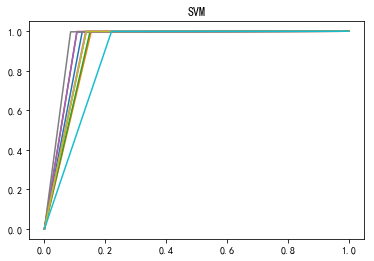

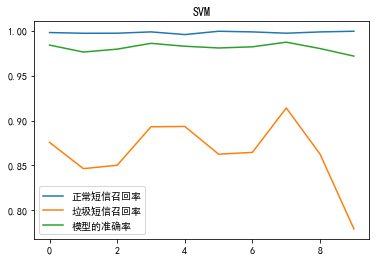

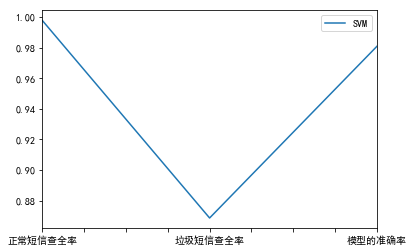

In [7]:
svc = SVC(kernel = 'linear')
clfs = {'SVM':svc}
a = []
figure_count = 0
key = 'SVM'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)

for i in range(10):
    print(key)
    print(i)
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b))

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

SVM
0
SVM
1
SVM
2
SVM
3
SVM
4
SVM
5
SVM
6
SVM
7
SVM
8
SVM
9


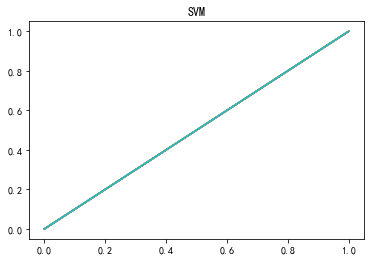

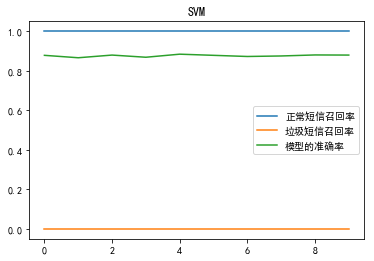

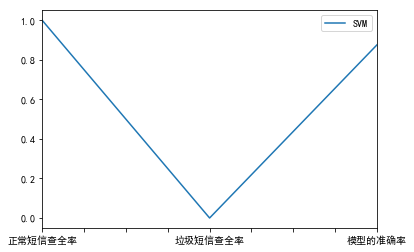

In [18]:
svc = SVC(kernel = 'poly', C = 1.0 , gamma = 100,tol = 0.001,degree = 4,coef0 = 0.0,class_weight = None)
clfs = {'SVM':svc}
a = []
figure_count = 0
key = 'SVM'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)

for i in range(10):
    print(key)
    print(i)
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 100 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b))

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

使用sigmoid核函数的测试

SVM
0
SVM
1
SVM
2
SVM
3
SVM
4
SVM
5
SVM
6
SVM
7
SVM
8
SVM
9


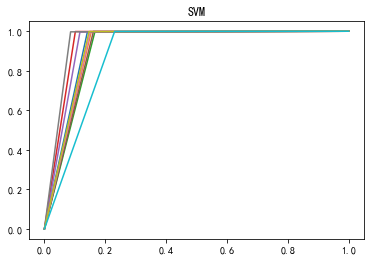

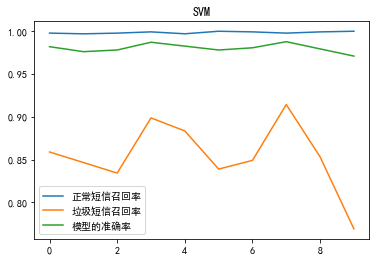

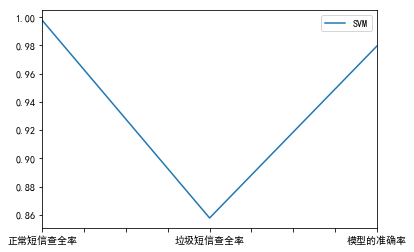

In [9]:
svc = SVC(kernel = 'sigmoid',gamma = 1.0)
clfs = {'SVM':svc}
a = []
figure_count = 0
key = 'SVM'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)

for i in range(10):
    print(key)
    print(i)
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b))

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

使用RBF核函数的测试

SVM
0
SVM
1
SVM
2
SVM
3
SVM
4
SVM
5
SVM
6
SVM
7
SVM
8
SVM
9


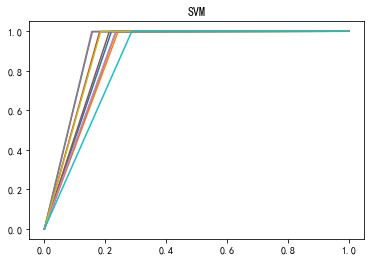

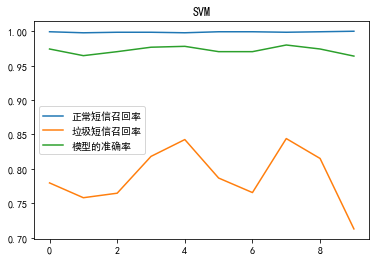

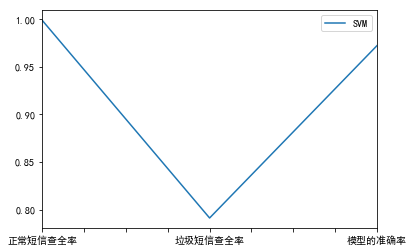

,正常短信查全率
0,0.999272
1,0.997754
2,0.998534
3,0.998534
4,0.997784
5,0.999254
6,0.999264
7,0.998535
8,0.999254
9,1.000000


In [19]:
svc = SVC(kernel = 'rbf',gamma = 1.0,tol = 0.001,class_weight = None , C = 1.0)
clfs = {'SVM':svc}
a = []
figure_count = 0
key = 'SVM'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)

for i in range(10):
    print(key)
    print(i)
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b))

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

count_list = pd.DataFrame()
count_list['正常短信查全率'] = recall.iloc[:,0]
count_list['垃圾短信查全率'] = recall.iloc[:,1]
count_list['模型准确率'] = recall.iloc[:,2]
print(count_list)
